In [1]:
import os
import yaml
import pickle
import matplotlib
from multiprocessing import Pool
from functools import partial

import torch
import numpy as np
import matplotlib.pyplot as plt
import bilby
import scipy
import torch
import pandas as pd
from pprint import pprint

matplotlib.use('pdf')
os.environ['MPLCONFIGDIR'] = '/home/local/nihargupte'
import dingo.gw.dataset.generate_dataset 
from dingo.gw.inference import injection
import dingo.gw.training.train_builders
import dingo.gw.waveform_generator
from dingo.gw.ASD_dataset.noise_dataset import ASDDataset
from dingo.gw.dataset import WaveformDataset
from dingo.gw.domains import build_domain, build_domain_from_model_metadata
import dingo.gw.inference
from dingo.gw.transforms import SelectStandardizeRepackageParameters, RepackageStrainsAndASDS, UnpackDict, SampleExtrinsicParameters, GNPECoalescenceTimes, AddWhiteNoiseComplex
from dingo.core.models import PosteriorModel
import dingo.gw.domains
from dingo.gw.inference.gw_samplers import GWSamplerGNPE, GWSampler

from utils import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-j4wmpi1l because the default path (/home/nihargupte/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
charizard_hex = ('#cd5241', '#084152', '#eede7b', '#207394', '#eeb45a', '#e64110', '#ff524a', '#f6a410', '#08398b', '#626262', '#833118')
plt.rcParams['text.usetex'] = False
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['font.size'] = 15
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=charizard_hex)

In [3]:
approximant = "SEOBNRv4HM_ROM"
special = "_O1_2048"
models_dir = "/home/local/nihargupte/dingo-devel/tutorials/03_aligned_spin"
train_dir = models_dir + f"/train_dir_{approximant}{special}"
waveform_generation_dir = (
    "/home/local/nihargupte/dingo-devel/tutorials/03_aligned_spin/datasets/waveforms"
)
os.environ[
    "LAL_DATA_PATH"
] = "/home/local/nihargupte/dingo-devel/venv/lib/python3.9/site-packages/lalsimulation/"

seob_device = 0
# build posterior model
torch.cuda.set_device(seob_device)
main_pm = PosteriorModel(
    device="cuda",
    **{"model_filename": f"{train_dir}/model_latest.pt"},
)

seob_time_pm = PosteriorModel(
    device='cuda',
    **{"model_filename": f"{models_dir}/train_dir_{approximant}{special}_time/model_latest.pt"}
)

init_sampler = GWSampler(model=seob_time_pm)
sampler = GWSamplerGNPE(model=main_pm, init_sampler=init_sampler, num_iterations=5)

injection_generator = injection.Injection.from_posterior_model_metadata(main_pm.metadata)
domain = build_domain_from_model_metadata(main_pm.metadata)
asd_dataset = ASDDataset(file_name=main_pm.metadata["train_settings"]["training"]["stage_0"]["asd_dataset_path"])
asd = asd_dataset.sample_random_asds()
injection_generator.asd = asd
asd = injection_generator.asd

Putting posterior model to device cuda.


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 39.44 GiB total capacity; 5.92 GiB already allocated; 17.50 MiB free; 5.99 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
%%capture
from bias import Bias1D

n_frames = 100
injection_parameters = {
    "mass_ratio": 0.5,
    "chirp_mass": 30.48907067184531,
    "chi_1": -0.75,
    "chi_2": -0.75,
    "phase": 0,  # rad
    "theta_jn": 0,  # rad inclination to maximize effect of higher modes
    "psi": 0.7,  # rad
    "ra": 0,  # rad
    "dec": 0,  # rad
    "geocent_time": 0.0,  # s
    "luminosity_distance": 410,  # Mpc
}
param1 = {
    "name":"mass_ratio",
    "sweep_array": np.linspace(0.2, 0.99, n_frames)
}
bias_1d = Bias1D(sampler, injection_generator, param1, injection_parameters)

interest_params = ["chirp_mass", "mass_ratio", "chi_1", "luminosity_distance"]
bias_1d.rescale_distance(16)
bias_1d.sweep(interest_params=interest_params)

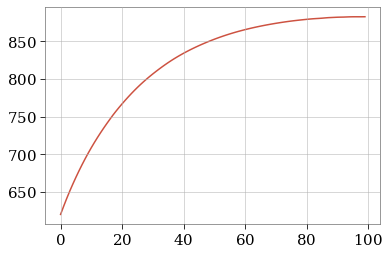

In [ ]:
plt.plot([bias_1d.posterior_list[idx]["truth"]["luminosity_distance"] for idx in range(len(bias_1d.posterior_list))])

In [ ]:
%%capture
bias_1d.save_frames_for_video(f"/home/local/nihargupte/dingo-devel/tutorials/05_data_vis/dumps/mass_ratio_bias")

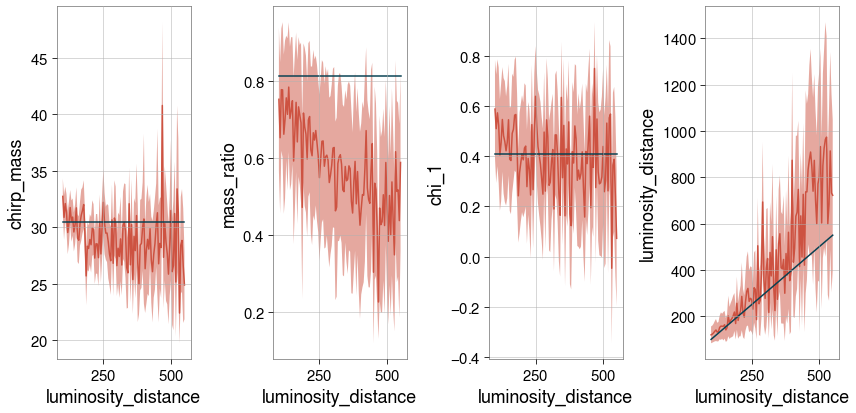

In [78]:
fig, axes = plt.subplots(1, 4, figsize=(12, 6))
bias_1d.plot(axes[0], "chirp_mass")
bias_1d.plot(axes[1], "mass_ratio")
bias_1d.plot(axes[2], "chi_1")
bias_1d.plot(axes[3], "luminosity_distance")
plt.tight_layout()

In [35]:
from bias import Bias2D

n_frames = 10
injection_parameters = {
    "mass_ratio": 0.5,
    "chirp_mass": 30.48907067184531,
    "chi_1": 0,
    "chi_2": 0,
    "phase": 0,  # rad
    "theta_jn": 0,  # rad inclination to maximize effect of higher modes
    "psi": 0.7,  # rad
    "ra": 0,  # rad
    "dec": 0,  # rad
    "geocent_time": 0.0,  # s
    "luminosity_distance": 600,  # Mpc
}
param1 = {
    "name":"mass_ratio",
    "sweep_array": np.linspace(0.125, 0.99, n_frames)
}
param2 = {
    "name": "effective_spin",
    "sweep_array": np.linspace(-1, 1, n_frames)
}
bias_2d = Bias2D(sampler, injection_generator, param1, param2, injection_parameters)

In [36]:
%%capture
bias_2d.rescale_distance(16)

In [37]:
%%capture
num_samples = 1_000
batch_size = 1_000
num_avg_points = 1
interest_params = ["chirp_mass", "mass_ratio", "luminosity_distance", "chi_1"]
bias_2d.sweep(num_samples, batch_size, num_avg_points, interest_params)

(100,) (100,) (100,)
309.5575026213396 1218.860604336695


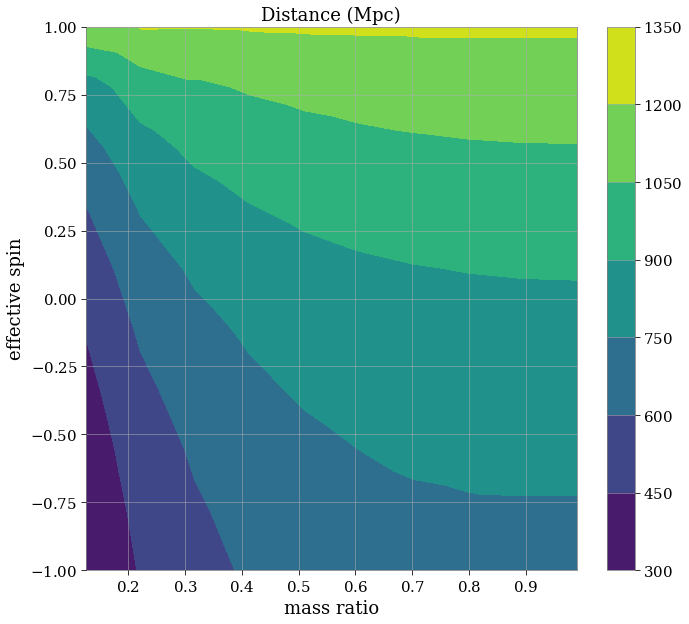

In [38]:
fig, ax = plt.subplots(1, figsize=(11, 10))

from matplotlib import colors
# divnorm=colors.TwoSlopeNorm(vcenter=0.)

plot_2d_kwargs = {
    "cmap":"RdBu",
    # "norm":divnorm,
    # "levels": [0, 1, 2, 3]
}
X = bias_2d.injection_parameters["mass_ratio"]
Y = bias_2d.injection_parameters["effective_spin"]
# Z = np.array([np.average(bias_2d.posterior_list.data_dict[idx]["snr"]).real for idx in bias_2d.posterior_list.index_vars])
Z = bias_2d.injection_parameters["luminosity_distance"]
print(X.shape, Y.shape, Z.shape)
print(Z.min(), Z.max())
ax = ax.tricontourf(X, Y, Z)

plt.xlabel("mass ratio")
plt.ylabel("effective spin")
plt.title(r"Distance (Mpc)")
plt.colorbar(ax)

plt.savefig("/home/local/nihargupte/dingo-devel/tutorials/07_bias/saved_plots/tricontourf/distance.png")

dict_keys(['truth', 'posteriors', 'snr'])


ValueError: operands could not be broadcast together with shapes (100,2,1,1000) (100,) 

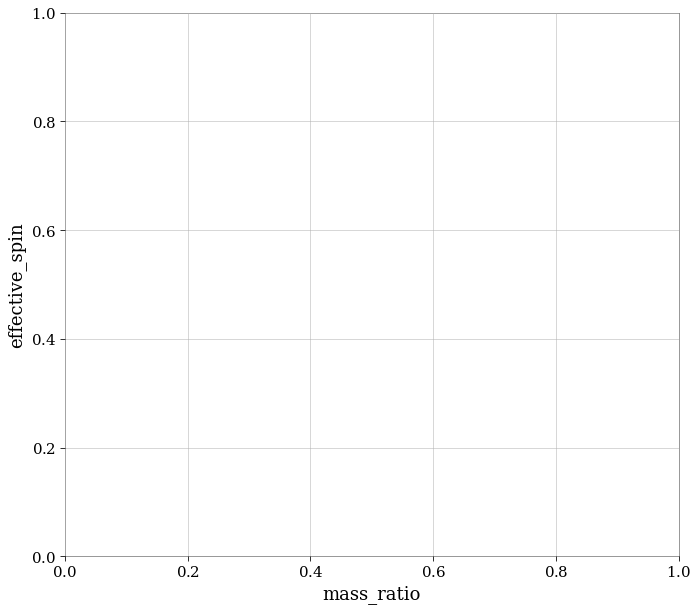

In [44]:
fig, ax = plt.subplots(1, figsize=(11, 10))
# bias_2d.posterior_list.data_dict[list(bias_2d.posterior_list.data_dict.keys())[-1]]

from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vcenter=0.)

plot_2d_kwargs = {
    "cmap":"RdBu",
    "norm":divnorm,
    # "levels": [-10, -5, 5, 10, 15, 20, 25, 30, 35, 40, 45]
}
ax = bias_2d.plot(ax, "chirp_mass", mode="mode", **plot_2d_kwargs)

plt.title(f"SEOBNRv4HM_ROM Injections SEOBNRv4HM_ROM Posterior Model\n" + r"$d_L$")
plt.colorbar(ax)
plt.savefig("/home/local/nihargupte/dingo-devel/tutorials/07_bias/saved_plots/tricontourf/d_L.png")

In [ ]:
# Scatter plot of luminosity_distance vs bias